# Prediction Models 
In this notebook, I undertake feature engineering and data preprocessing, before creating models for prediction of late returns. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1">imports</a></span></li><li><span><a href="#loading-data" data-toc-modified-id="loading-data-2">loading data</a></span><ul class="toc-item"><li><span><a href="#renaming-ID-variables,-for-easier-merging" data-toc-modified-id="renaming-ID-variables,-for-easier-merging-2.1">renaming ID variables, for easier merging</a></span></li></ul></li><li><span><a href="#feature-engineering" data-toc-modified-id="feature-engineering-3">feature engineering</a></span><ul class="toc-item"><li><span><a href="#dropping-variables-irrelevant-to-the-problem" data-toc-modified-id="dropping-variables-irrelevant-to-the-problem-3.1">dropping variables irrelevant to the problem</a></span></li><li><span><a href="#merging-into-single-dataframe" data-toc-modified-id="merging-into-single-dataframe-3.2">merging into single dataframe</a></span></li><li><span><a href="#dropping-missing-value" data-toc-modified-id="dropping-missing-value-3.3">dropping missing value</a></span></li><li><span><a href="#additional-feature:--distance-between-library-and-patron-addresses" data-toc-modified-id="additional-feature:--distance-between-library-and-patron-addresses-3.4">additional feature:  distance between library and patron addresses</a></span></li><li><span><a href="#additional-feature:-patron-age" data-toc-modified-id="additional-feature:-patron-age-3.5">additional feature: patron age</a></span></li><li><span><a href="#comparing-mean-values-across-late-and-timely-returns" data-toc-modified-id="comparing-mean-values-across-late-and-timely-returns-3.6">comparing mean values across late and timely returns</a></span></li><li><span><a href="#examining-categorical-variables" data-toc-modified-id="examining-categorical-variables-3.7">examining categorical variables</a></span><ul class="toc-item"><li><span><a href="#gender" data-toc-modified-id="gender-3.7.1">gender</a></span></li><li><span><a href="#education" data-toc-modified-id="education-3.7.2">education</a></span></li><li><span><a href="#occupation" data-toc-modified-id="occupation-3.7.3">occupation</a></span></li><li><span><a href="#categories" data-toc-modified-id="categories-3.7.4">categories</a></span></li></ul></li></ul></li><li><span><a href="#data-preparation-for-ML-models" data-toc-modified-id="data-preparation-for-ML-models-4">data preparation for ML models</a></span><ul class="toc-item"><li><span><a href="#one-hot-encoding-categorical-variables" data-toc-modified-id="one-hot-encoding-categorical-variables-4.1">one-hot encoding categorical variables</a></span></li><li><span><a href="#separating-features-and-target" data-toc-modified-id="separating-features-and-target-4.2">separating features and target</a></span></li><li><span><a href="#generating-train-test-split" data-toc-modified-id="generating-train-test-split-4.3">generating train-test split</a></span></li></ul></li><li><span><a href="#MODEL-0:-Majority-Class-Predictor" data-toc-modified-id="MODEL-0:-Majority-Class-Predictor-5">MODEL 0: Majority Class Predictor</a></span></li><li><span><a href="#MODEL-1:-Logistic-Regression-Model" data-toc-modified-id="MODEL-1:-Logistic-Regression-Model-6">MODEL 1: Logistic Regression Model</a></span><ul class="toc-item"><li><span><a href="#training" data-toc-modified-id="training-6.1">training</a></span></li><li><span><a href="#evaluation" data-toc-modified-id="evaluation-6.2">evaluation</a></span><ul class="toc-item"><li><span><a href="#accuracy" data-toc-modified-id="accuracy-6.2.1">accuracy</a></span></li><li><span><a href="#classification-report" data-toc-modified-id="classification-report-6.2.2">classification report</a></span></li><li><span><a href="#confusion-matrix" data-toc-modified-id="confusion-matrix-6.2.3">confusion matrix</a></span></li></ul></li></ul></li><li><span><a href="#MODEL-2:-Random-Forest" data-toc-modified-id="MODEL-2:-Random-Forest-7">MODEL 2: Random Forest</a></span><ul class="toc-item"><li><span><a href="#training" data-toc-modified-id="training-7.1">training</a></span></li><li><span><a href="#evaluation" data-toc-modified-id="evaluation-7.2">evaluation</a></span><ul class="toc-item"><li><span><a href="#accuracy" data-toc-modified-id="accuracy-7.2.1">accuracy</a></span></li><li><span><a href="#classification-report" data-toc-modified-id="classification-report-7.2.2">classification report</a></span></li><li><span><a href="#confusion-matrix" data-toc-modified-id="confusion-matrix-7.2.3">confusion matrix</a></span></li></ul></li></ul></li><li><span><a href="#MODEL-3:-Naive-Bayes-Classifier" data-toc-modified-id="MODEL-3:-Naive-Bayes-Classifier-8">MODEL 3: Naive Bayes Classifier</a></span><ul class="toc-item"><li><span><a href="#training" data-toc-modified-id="training-8.1">training</a></span></li><li><span><a href="#evaluation" data-toc-modified-id="evaluation-8.2">evaluation</a></span></li></ul></li><li><span><a href="#MODEL-4:-Gradient-Boosted-Decision-Tree" data-toc-modified-id="MODEL-4:-Gradient-Boosted-Decision-Tree-9">MODEL 4: Gradient-Boosted Decision Tree</a></span><ul class="toc-item"><li><span><a href="#training" data-toc-modified-id="training-9.1">training</a></span></li></ul></li><li><span><a href="#evaluation" data-toc-modified-id="evaluation-10">evaluation</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#accuracy" data-toc-modified-id="accuracy-10.0.1">accuracy</a></span></li><li><span><a href="#classification-report" data-toc-modified-id="classification-report-10.0.2">classification report</a></span></li><li><span><a href="#confusion-matrix" data-toc-modified-id="confusion-matrix-10.0.3">confusion matrix</a></span></li></ul></li></ul></li><li><span><a href="#MODEL-5:-RANDOM-FOREST-w/-OPTUNA-HYPERPARAMETER-OPTIMIZATION" data-toc-modified-id="MODEL-5:-RANDOM-FOREST-w/-OPTUNA-HYPERPARAMETER-OPTIMIZATION-11">MODEL 5: RANDOM FOREST w/ OPTUNA HYPERPARAMETER OPTIMIZATION</a></span><ul class="toc-item"><li><span><a href="#training" data-toc-modified-id="training-11.1">training</a></span></li><li><span><a href="#evaluation" data-toc-modified-id="evaluation-11.2">evaluation</a></span><ul class="toc-item"><li><span><a href="#accuracy" data-toc-modified-id="accuracy-11.2.1">accuracy</a></span></li><li><span><a href="#classification-report" data-toc-modified-id="classification-report-11.2.2">classification report</a></span></li><li><span><a href="#confusion-matrix" data-toc-modified-id="confusion-matrix-11.2.3">confusion matrix</a></span></li></ul></li></ul></li><li><span><a href="#MODEL-COMPARISON" data-toc-modified-id="MODEL-COMPARISON-12">MODEL COMPARISON</a></span></li></ul></div>

## imports 

In [1]:
import os, sys, glob # for loading, saving and manipulating files on disk
from pathlib import Path # Path allows us to list directory paths in a manner that's not affected by the OS the notebook is being run on 

import pandas as pd # to work with csv files as dataframes 
import numpy as np # for mathematical and scientific computations 

import matplotlib.pyplot as plt # for plots 
import seaborn as sns # also for plotting, it's a wrapper for several matplotlib functions, making them more accessible 

from haversine import haversine, Unit # for computing distances between geocodes

from IPython.core.display import display, HTML # to change width of notebooks
display(HTML("<style>.container { width:100% !important; }</style>"))

## loading data

In [2]:
raw_data_dir = Path.home()/'projects'/'billups_data_challenge'/'Data Challenge' # specifies the directory with data files
cleaned_data_dir = raw_data_dir.parent/'cleaned_data' # directory for storing intermediate outputs such as cleaned data

In [3]:
lib_df = pd.read_csv(cleaned_data_dir/'libraries_cleaned_geocoded.csv')
books_checkouts_df = pd.read_csv(cleaned_data_dir/'books_checkouts_merged.csv')
customers_df = pd.read_csv(cleaned_data_dir/'customers_cleaned_geocoded.csv')

### renaming ID variables, for easier merging

In [4]:
lib_df.rename(columns={'id':'library_id', 'lat':'library_lat', 'long':'library_long', 'name':'library_name'}, inplace=True)
books_checkouts_df.rename(columns={'id':'book_id'}, inplace=True)
customers_df.rename(columns={'id':'patron_id', 'name':'patron_name', 'lat':'patron_lat', 'long':'patron_long'}, inplace=True)

## feature engineering

### dropping variables irrelevant to the problem

Certain variables do not contain information that would be useful for predicting late returns, or that information is already contained in other variables. Here I provide a brief description of such variables: 
- **library name**: the name of the library doesn't matter, it's already identified by the library ID. And it's location is geocoded 
- **customer name**: this variable has high cardinality, and I expect there to be no relation between names and later returns 
- **library address** & **customer address**: both of these are geocoded, so we can work with lat-long directly and don't need full addresses 
- **publisher**&**published date**: my prior is that publisher name doesn't affect late returns except through pages, prices, and categories, both of which are present as independent variables
- **author names** & **title**: again, my prior is that the variables through which authors may affect the late return, already exist in the data 
- **duration_borrowed_days**, **date_returned**, **return_year**: these are not irrelevant variables. They were generated using "date_returned" and therefore contain information that won't be available to the library when a book is being checked out, so using these would result in _data leakage_ in our model. 
- **date_due**: characteristics of this variable have already been extracted in the form of weekday, month, day-of-the-month, so it provides no extra information

In [5]:
lib_df = lib_df[['library_id', 'library_lat', 'library_long']]
books_checkouts_df.drop(columns=['publisher', 'authors', 'title', 'publishedDate', 'date_returned', 'return_year', 'duration_borrowed_days', 'date_due'], inplace=True)
customers_df = customers_df[['patron_id', 'patron_lat', 'patron_long', 'birth_year', 'gender', 'education', 'occupation']]

### merging into single dataframe

In [6]:
df = books_checkouts_df.merge(lib_df, on='library_id', how='outer')
df = df.merge(customers_df, on='patron_id', how='outer')

### dropping missing value
- during cleaning and EDA, I had imputed missing values wherever I could without influencing the target variable 
- I drop the remaining missing values

In [7]:
df = df.dropna(axis=0, how='any')

### additional feature:  distance between library and patron addresses 
 I want to create this feature, as I believe that the further the library is from patron homes, the more likely they might be to return late. 

In [8]:
df['library_loc'] = list(zip(df['library_lat'], df['library_long']))
df['patron_loc'] = list(zip(df['patron_lat'], df['patron_long']))

In [9]:
df['distance_lib_patron_km'] = df.apply(lambda x: haversine(x['library_loc'], x['patron_loc'], unit=Unit.METERS), axis=1)/1000

### additional feature: patron age

In [10]:
df['patron_age'] = 2022 - df['birth_year']
df = df[df['patron_age']<=120]

### comparing mean values across late and timely returns

In [11]:
df.groupby('late_return_indicator').mean()

,price,pages,checkout_year,due_date_is_holiday,closest_holiday_distance,library_lat,library_long,patron_lat,patron_long,birth_year,distance_lib_patron_km,patron_age
late_return_indicator,,,,,,,,,,,,
0.0,293.308421,570.647954,2018.00000,0.022835,13.185538,45.529006,-122.657432,45.537268,-122.655193,1980.424358,4.571822,41.575642
1.0,338.899506,648.092593,1951.04321,0.043210,24389.765432,45.530503,-122.660162,45.528872,-122.653868,1979.271605,7.378124,42.728395


- books with late returns are longer and costlier
- patrons associated with late returns on average live 3km further from the library 
- this table indicates that price, pages and distance are important features for predicting late returns

### examining categorical variables

In [12]:
df.select_dtypes(include='object').nunique()

book_id          197
categories        86
patron_id        949
library_id        18
date_checkout    387
gender             8
education         30
occupation        51
library_loc       18
patron_loc       904
dtype: int64

- there are 7 categorical variables 
- of these 7 variable, 3 are IDs, leaving us with 4 categorical variables: gender, education, occupation, categories
-  the cardinality of each of the 4 categorical columns seems high, so we reduce that 

#### gender

In [13]:
df['gender'].unique()

array(['male', 'female', ' male', ' female', 'MALE', 'FEMALE', 'male ',
       'female '], dtype=object)

In [14]:
df['gender'] = df['gender'].str.strip().str.upper()

In [15]:
df.groupby('gender').mean()

,price,pages,checkout_year,late_return_indicator,due_date_is_holiday,closest_holiday_distance,library_lat,library_long,patron_lat,patron_long,birth_year,distance_lib_patron_km,patron_age
gender,,,,,,,,,,,,,
FEMALE,298.507092,571.346812,2011.136858,0.094868,0.024883,2511.295490,45.531093,-122.658125,45.539314,-122.652988,1980.183515,4.908075,41.816485
MALE,300.401421,591.870175,2006.712281,0.177193,0.026316,4123.222807,45.527077,-122.657426,45.532574,-122.657305,1980.368421,4.990085,41.631579


- Males are 8pp more likely to return books late

#### education

In [16]:
df['education'].fillna('n/a', inplace=True)

In [17]:
df['education']= df['education'].str.strip().str.lower().apply(lambda x: ' '.join(x.split()))

In [18]:
df['education'].unique()

array(['college', 'graduate degree', 'high school', 'others'],
      dtype=object)

In [19]:
df.groupby('education').mean()

,price,pages,checkout_year,late_return_indicator,due_date_is_holiday,closest_holiday_distance,library_lat,library_long,patron_lat,patron_long,birth_year,distance_lib_patron_km,patron_age
education,,,,,,,,,,,,,
college,323.564548,598.645161,2008.538710,0.119355,0.048387,3456.600000,45.535709,-122.668483,45.544499,-122.663432,1980.193548,4.766534,41.806452
graduate degree,287.656203,559.808271,2009.338346,0.112782,0.011278,3168.244361,45.527819,-122.657753,45.531083,-122.657906,1982.466165,4.782645,39.533835
high school,282.820298,583.357143,2011.273810,0.172619,0.017857,2462.479167,45.531208,-122.658197,45.537139,-122.651529,1980.547619,5.079715,41.452381
others,303.387674,578.887043,2006.870432,0.122924,0.023256,4064.146179,45.521500,-122.646381,45.530914,-122.647690,1978.099668,5.128397,43.900332


- patrons with college education most likely to return books late
- followed by patrons with high school education level 
- and then graduate degree holders

#### occupation

In [20]:
df['occupation'].fillna('n/a', inplace=True)

In [21]:
df['occupation'] = df['occupation'].str.strip().str.lower().apply(lambda x: ' '.join(x.split()))

In [22]:
df['occupation'].unique()

array(['admin & support', 'sales', 'business & finance', 'blue collar',
       'others', 'education & health', 'tech'], dtype=object)

In [23]:
df.groupby('occupation').mean()

,price,pages,checkout_year,late_return_indicator,due_date_is_holiday,closest_holiday_distance,library_lat,library_long,patron_lat,patron_long,birth_year,distance_lib_patron_km,patron_age
occupation,,,,,,,,,,,,,
admin & support,314.108962,600.295082,2006.743169,0.131148,0.021858,4109.896175,45.529458,-122.664162,45.532500,-122.659875,1978.573770,4.716067,43.426230
blue collar,292.877862,594.558621,2008.000000,0.110345,0.027586,3652.103448,45.527748,-122.659299,45.542666,-122.657759,1982.193103,4.809364,39.806897
business & finance,279.141688,546.767932,2012.603376,0.130802,0.012658,1978.898734,45.529003,-122.648458,45.551270,-122.649650,1977.088608,5.656734,44.911392
education & health,309.983312,583.375000,2009.000000,0.125000,0.025000,3290.425000,45.530006,-122.648187,45.532281,-122.647344,1980.837500,4.387772,41.162500
others,306.806647,592.676301,2009.601156,0.109827,0.017341,3069.427746,45.529713,-122.658396,45.534302,-122.651692,1979.554913,5.171812,42.445087
sales,298.357170,580.069182,2002.081761,0.138365,0.050314,5809.106918,45.526715,-122.666479,45.520556,-122.658836,1982.880503,4.710491,39.119497
tech,300.957628,583.262821,2013.935897,0.192308,0.032051,1494.923077,45.531732,-122.663460,45.533293,-122.662584,1982.858974,4.829884,39.141026


- patrons working in sales most likely to return books late 

#### categories

In [24]:
df['categories'].unique()

array(["['Social Science']", "['Advertising']",
       "['Business & Economics']", "['Technology & Engineering']",
       "['Mechanics, Applied']", "['Technology']", "['Medical']",
       "['Bacteriology']", "['Medicine']",
       "['Financial services industry']", "['Banks and banking']",
       "['Political Science']", "['Desarrollo economico']",
       "['Internal combustion engines']", "['Science']", "['Philosophy']",
       "['Computers']", "['Water resources development']",
       "['United States']", "['Water-supply']", "['Natural resources']",
       "['Environmental law']", "['Psychology']", "['Mechanics']",
       "['Mechanical engineering']", "['Mechanics, Analytic']",
       "['Electronic books']", "['Government publications']",
       "['Banking law']", "['Financial institutions']", "['Finance']",
       "['Corporations']", "['Diesel engines']", "['Transportation']",
       "['Juvenile Fiction']", "['Conservation of natural resources']",
       "['Agricultural education']"

- the cardinality of the categories variable is really high, so I try to create other categories using this. Primarily, fiction and non-fiction

In [25]:
df['categories'].fillna('n/a', inplace=True)

In [26]:
df['new_category'] = np.where(df['categories'].str.contains('Ficti'), 'Fiction', 'Non-Fiction')

In [27]:
df.drop(columns=['categories'], inplace=True)

In [28]:
df.groupby('new_category').mean()

,price,pages,checkout_year,late_return_indicator,due_date_is_holiday,closest_holiday_distance,library_lat,library_long,patron_lat,patron_long,birth_year,distance_lib_patron_km,patron_age
new_category,,,,,,,,,,,,,
Fiction,283.974583,628.291667,2018.000000,0.041667,0.000000,18.791667,45.530019,-122.654665,45.537878,-122.645333,1982.458333,4.034159,39.541667
Non-Fiction,299.708562,580.036165,2008.877208,0.135408,0.026072,3334.355761,45.529190,-122.657860,45.536112,-122.655212,1980.226241,4.965031,41.773759


- non-fiction books considerably more likely to be returned late than fiction books 

## data preparation for ML models 

### one-hot encoding categorical variables 

In [29]:
ohe_gender = pd.get_dummies(df['gender'])
ohe_education = pd.get_dummies(df['education'], prefix='edu')
ohe_occupation = pd.get_dummies(df['occupation'], prefix='job')
ohe_book_category = pd.get_dummies(df['new_category'])

In [30]:
df = df.join([ohe_gender, ohe_education, ohe_occupation, ohe_book_category])

### separating features and target

In [31]:
y = df['late_return_indicator']
X = df.drop(columns=['book_id', 'patron_id', 'library_id', 'library_loc', 'patron_loc', 
             'gender', 'occupation', 'education', 'new_category', 'late_return_indicator', 'date_checkout', 'birth_year'])

### generating train-test split 

I want to split my test into three sets: 
- **Train** : these observations will be used to train the model to learn
- **Validation**: this subset serves the purpose of model selection. So, I want to be able to try different hyperparameters, and knowing which hyperparameters are better suited for my model would require me to "test" it on a dataset that is not seen. 
- **Test**: this is a hold-out set, used to indicate the final performance of the "best model" selected using the validation set performance

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=7) #10% of the data is held out 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7) # 1/4th of the training data is used for validation

# Models:

In [33]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, recall_score, roc_auc_score, accuracy_score
from sklearn.feature_selection import RFE 

In [34]:
# variables to store model performances, for easier comparison 
models = {}
overall_accuracy = []
late_return_accuracy = []
auc_score = []

## MODEL 0: Majority Class Predictor
This is our benchmark model. This model simply predicts the majority class in the training sample. It's a very very naive model, but serves as a good baseline for evaluating the performance of our ML models, especially in cases when there is a class imbalance in the training data, which is the case with our data. 

In [35]:
models.update({'m0':'majority_class_predictor'})

In [36]:
y_pred_m0 = [y_train.mode()]*len(y_val) # simply predicts the majority-class in the training sample

In [37]:
print(classification_report(y_val, y_pred_m0))

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93       236
         1.0       0.00      0.00      0.00        37

    accuracy                           0.86       273
   macro avg       0.43      0.50      0.46       273
weighted avg       0.75      0.86      0.80       273



/Users/garima/miniconda3/envs/reloc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/garima/miniconda3/envs/reloc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/garima/miniconda3/envs/reloc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

- this model is able achieve an overall accuracy of 86% even with a constant prediction. This is because the majority class in our training data is also the predominant majority class in the validation set. 
- the absolute minimum accuracy we should be able to achieve with more complex models is 86%
- however, the library doesn't necessarily care about "overall accuracy" but ability to predict defaults, i.e the recall value for the "1" class, which in this case is zero.

<AxesSubplot:>

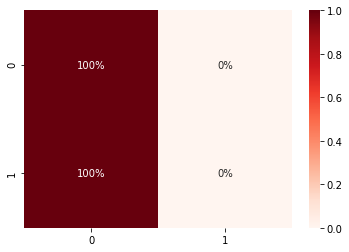

In [38]:
cm_m0= confusion_matrix(y_val, y_pred_m0, normalize='true')
sns.heatmap(cm_m0, annot=True, fmt='.0%', cmap='Reds')

In [39]:
overall_accuracy.append(accuracy_score(y_val, y_pred_m0))
late_return_accuracy.append(recall_score(y_val, y_pred_m0))
auc_score.append(roc_auc_score(y_val, y_pred_m0))

## MODEL 1: Logistic Regression Model 

In [40]:
from sklearn.linear_model import LogisticRegression
models.update({'m1':'logit_reg'})

### training 

In [41]:
m1_lr = LogisticRegression()
m1_lr.fit(X_train, y_train);

/Users/garima/miniconda3/envs/reloc/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### evaluation

In [42]:
y_pred_m1 = m1_lr.predict(X_val) #using X_test and not X_val here because not tuning hyperparameters for logistic regression

#### accuracy

In [43]:
print(f"Accuracy of the LogisticRegression model is {round(m1_lr.score(X_val, y_val), 3)*100}%")

Accuracy of the LogisticRegression model is 89.7%


#### classification report

In [44]:
print(classification_report(y_val, y_pred_m1))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       236
         1.0       0.76      0.35      0.48        37

    accuracy                           0.90       273
   macro avg       0.84      0.67      0.71       273
weighted avg       0.89      0.90      0.88       273



#### confusion matrix 

<AxesSubplot:>

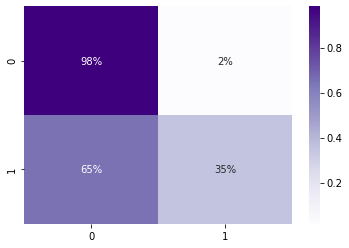

In [45]:
cm= confusion_matrix(y_val, y_pred_m1, normalize='true')
sns.heatmap(cm, annot=True, fmt='.0%', cmap='Purples')

The Logistic Regression model classifies timely returns as timely 99% of the time, and the late returns as late 73% of the time. Given that the library is interested in monitoring and predicting late returns, the metric we care most about is the recall value for late-returns. 

In [46]:
overall_accuracy.append(accuracy_score(y_val, y_pred_m1))
late_return_accuracy.append(recall_score(y_val, y_pred_m1))
auc_score.append(roc_auc_score(y_val, y_pred_m1))

## MODEL 2: Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
models.update({'m2':'random_forest'})

### training

In [48]:
def get_best_max_depth(): 
    max_depth_accuracy = []
    for i in range(1,25): 
        model = RandomForestClassifier(max_depth=i, random_state=7)
        model.fit(X_train, y_train)
        max_depth_accuracy.append(model.score(X_val, y_val))
    max_accuracy = max(max_depth_accuracy)
    best_max_depth = max_depth_accuracy.index(max_accuracy)
    return best_max_depth

In [49]:
m2_rf= RandomForestClassifier(max_depth=get_best_max_depth(), random_state=7)
m2_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, random_state=7)


### evaluation

In [50]:
y_pred_m2 = m2_rf.predict(X_val)

#### accuracy

In [51]:
print(f"Accuracy of the Random Forest model is {round(m2_rf.score(X_val, y_val), 4)*100}%")

Accuracy of the Random Forest model is 95.6%


#### classification report

In [52]:
print(classification_report(y_val, y_pred_m2))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       236
         1.0       0.96      0.70      0.81        37

    accuracy                           0.96       273
   macro avg       0.96      0.85      0.89       273
weighted avg       0.96      0.96      0.95       273



#### confusion matrix 

<AxesSubplot:>

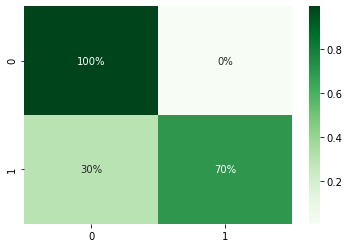

In [53]:
cm_m2 = confusion_matrix(y_val, y_pred_m2, normalize='true')
sns.heatmap(cm_m2, annot=True, fmt='.0%', cmap='Greens')

<AxesSubplot:title={'center':'Top 10 Features'}>

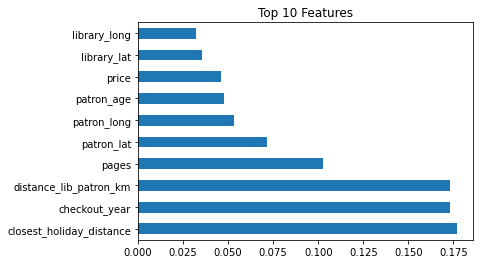

In [54]:
fi_df= pd.Series(m2_rf.feature_importances_, index=X.columns)
fi_df.sort_values(ascending=False, inplace=True)
fi_df.head(10).plot(kind='barh', title='Top 10 Features')

In [55]:
overall_accuracy.append(accuracy_score(y_val, y_pred_m2))
late_return_accuracy.append(recall_score(y_val, y_pred_m2))
auc_score.append(roc_auc_score(y_val, y_pred_m2))

## MODEL 3: Naive Bayes Classifier

In [56]:
from sklearn.naive_bayes import GaussianNB
models.update({'m3':'naive_bayes'})

### training 

In [57]:
m3_nb = GaussianNB()
m3_nb.fit(X_train, y_train)

GaussianNB()

### evaluation

In [58]:
y_pred_m3 = m3_nb.predict(X_val)

In [59]:
print(classification_report(y_val, y_pred_m3))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       236
         1.0       1.00      0.16      0.28        37

    accuracy                           0.89       273
   macro avg       0.94      0.58      0.61       273
weighted avg       0.90      0.89      0.85       273



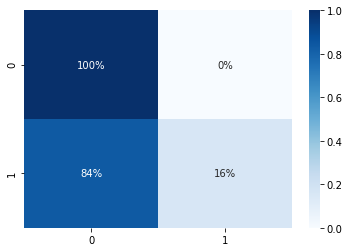

In [60]:
cm_m3 = confusion_matrix(y_val, y_pred_m3, normalize='true')
sns.heatmap(cm_m3, annot=True, cmap='Blues',fmt='.0%');

In [61]:
overall_accuracy.append(accuracy_score(y_val, y_pred_m3))
late_return_accuracy.append(recall_score(y_val, y_pred_m3))
auc_score.append(roc_auc_score(y_val, y_pred_m3))

## MODEL 4: Gradient-Boosted Decision Tree

In [62]:
import lightgbm as lgb
models.update({'m4':'lgb_gbdt'})

### training

In [63]:
m4_lgb = lgb.LGBMClassifier()
m4_lgb.fit(X_train, y_train)

LGBMClassifier()

## evaluation

In [64]:
y_pred_m4 = m4_lgb.predict(X_val)

#### accuracy

In [65]:
print(f"Accuracy of the Random Forest model is {round(m2_rf.score(X_val, y_val), 4)*100}%")

Accuracy of the Random Forest model is 95.6%


#### classification report

In [66]:
print(classification_report(y_val, y_pred_m4))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       236
         1.0       0.88      0.76      0.81        37

    accuracy                           0.95       273
   macro avg       0.92      0.87      0.89       273
weighted avg       0.95      0.95      0.95       273



#### confusion matrix

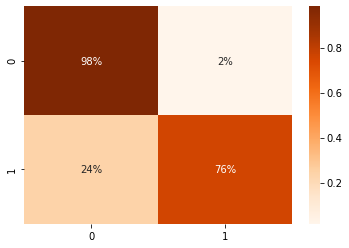

In [67]:
cm_m4 = confusion_matrix(y_val, y_pred_m4, normalize='true')
sns.heatmap(cm_m4, annot=True, cmap='Oranges',fmt='.0%');

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

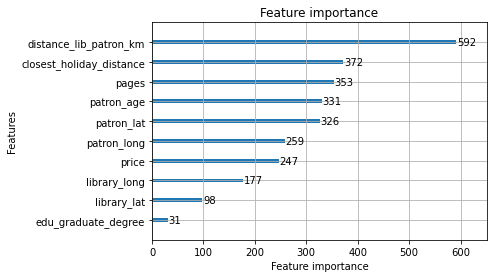

In [68]:
lgb.plot_importance(m4_lgb, max_num_features=10)

In [69]:
overall_accuracy.append(accuracy_score(y_val, y_pred_m4))
late_return_accuracy.append(recall_score(y_val, y_pred_m4))
auc_score.append(roc_auc_score(y_val, y_pred_m4))

## MODEL 5: RANDOM FOREST w/ OPTUNA HYPERPARAMETER OPTIMIZATION

In [70]:
import optuna
models.update({'m5':'rf_w_optuna'})

In [71]:
def objective(trial): 
    classifier_name = 'RandomForest'
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 10, 500)
    rf_max_depth = trial.suggest_int('rf_max_depth', 1, 25)
    model = RandomForestClassifier(max_depth=rf_max_depth, n_estimators= rf_n_estimators)
    model.fit(X_train, y_train)
    score = recall_score(y_val, model.predict(X_val))
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100);

[I 2022-08-08 18:52:39,440] A new study created in memory with name: no-name-718224a5-029d-4fb5-92c8-32fa0bcaf78c
[I 2022-08-08 18:52:39,854] Trial 0 finished with value: 0.2702702702702703 and parameters: {'rf_n_estimators': 163, 'rf_max_depth': 4}. Best is trial 0 with value: 0.2702702702702703.
[I 2022-08-08 18:52:40,467] Trial 1 finished with value: 0.5135135135135135 and parameters: {'rf_n_estimators': 430, 'rf_max_depth': 6}. Best is trial 1 with value: 0.5135135135135135.
[I 2022-08-08 18:52:40,600] Trial 2 finished with value: 0.6756756756756757 and parameters: {'rf_n_estimators': 87, 'rf_max_depth': 14}. Best is trial 2 with value: 0.6756756756756757.
[I 2022-08-08 18:52:40,738] Trial 3 finished with value: 0.2702702702702703 and parameters: {'rf_n_estimators': 98, 'rf_max_depth': 4}. Best is trial 2 with value: 0.6756756756756757.
[I 2022-08-08 18:52:40,832] Trial 4 finished with value: 0.7027027027027027 and parameters: {'rf_n_estimators': 48, 'rf_max_depth': 21}. Best is tr

[I 2022-08-08 18:52:49,833] Trial 41 finished with value: 0.6486486486486487 and parameters: {'rf_n_estimators': 88, 'rf_max_depth': 15}. Best is trial 4 with value: 0.7027027027027027.
[I 2022-08-08 18:52:49,901] Trial 42 finished with value: 0.5945945945945946 and parameters: {'rf_n_estimators': 35, 'rf_max_depth': 21}. Best is trial 4 with value: 0.7027027027027027.
[I 2022-08-08 18:52:50,080] Trial 43 finished with value: 0.6756756756756757 and parameters: {'rf_n_estimators': 116, 'rf_max_depth': 24}. Best is trial 4 with value: 0.7027027027027027.
[I 2022-08-08 18:52:50,279] Trial 44 finished with value: 0.6216216216216216 and parameters: {'rf_n_estimators': 133, 'rf_max_depth': 25}. Best is trial 4 with value: 0.7027027027027027.
[I 2022-08-08 18:52:50,312] Trial 45 finished with value: 0.6756756756756757 and parameters: {'rf_n_estimators': 12, 'rf_max_depth': 18}. Best is trial 4 with value: 0.7027027027027027.
[I 2022-08-08 18:52:50,346] Trial 46 finished with value: 0.70270270

[I 2022-08-08 18:53:00,038] Trial 83 finished with value: 0.6486486486486487 and parameters: {'rf_n_estimators': 301, 'rf_max_depth': 22}. Best is trial 4 with value: 0.7027027027027027.
[I 2022-08-08 18:53:00,601] Trial 84 finished with value: 0.6216216216216216 and parameters: {'rf_n_estimators': 366, 'rf_max_depth': 11}. Best is trial 4 with value: 0.7027027027027027.
[I 2022-08-08 18:53:01,332] Trial 85 finished with value: 0.6216216216216216 and parameters: {'rf_n_estimators': 499, 'rf_max_depth': 18}. Best is trial 4 with value: 0.7027027027027027.
[I 2022-08-08 18:53:01,522] Trial 86 finished with value: 0.6216216216216216 and parameters: {'rf_n_estimators': 125, 'rf_max_depth': 25}. Best is trial 4 with value: 0.7027027027027027.
[I 2022-08-08 18:53:01,654] Trial 87 finished with value: 0.6216216216216216 and parameters: {'rf_n_estimators': 74, 'rf_max_depth': 22}. Best is trial 4 with value: 0.7027027027027027.
[I 2022-08-08 18:53:01,771] Trial 88 finished with value: 0.540540

In [72]:
study.best_trial

FrozenTrial(number=90, values=[0.7297297297297297], datetime_start=datetime.datetime(2022, 8, 8, 18, 53, 1, 843364), datetime_complete=datetime.datetime(2022, 8, 8, 18, 53, 1, 922281), params={'rf_n_estimators': 41, 'rf_max_depth': 21}, distributions={'rf_n_estimators': IntUniformDistribution(high=500, low=10, step=1), 'rf_max_depth': IntUniformDistribution(high=25, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=90, state=TrialState.COMPLETE, value=None)

In [73]:
print(study.best_params)

{'rf_n_estimators': 41, 'rf_max_depth': 21}


### training

In [74]:
m5_rf= RandomForestClassifier(max_depth=study.best_params['rf_max_depth'], n_estimators=study.best_params['rf_n_estimators'], random_state=7)
m5_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=21, n_estimators=41, random_state=7)


### evaluation

In [75]:
y_pred_m5 = m5_rf.predict(X_val)

#### accuracy

In [76]:
print(f"Accuracy of the Random Forest model is {round(m5_rf.score(X_val, y_val), 4)*100}%")

Accuracy of the Random Forest model is 95.6%


#### classification report

In [77]:
print(classification_report(y_val, y_pred_m5))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98       236
         1.0       1.00      0.68      0.81        37

    accuracy                           0.96       273
   macro avg       0.98      0.84      0.89       273
weighted avg       0.96      0.96      0.95       273



#### confusion matrix 

<AxesSubplot:>

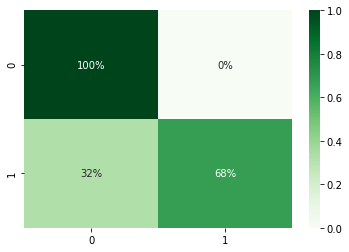

In [78]:
cm_m5 = confusion_matrix(y_val, y_pred_m5, normalize='true')
sns.heatmap(cm_m5, annot=True, fmt='.0%', cmap='Greens')

<AxesSubplot:title={'center':'Top 10 Features'}>

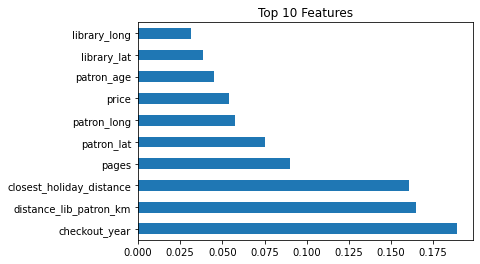

In [79]:
fi_df= pd.Series(m5_rf.feature_importances_, index=X.columns)
fi_df.sort_values(ascending=False, inplace=True)
fi_df.head(10).plot(kind='barh', title='Top 10 Features')

In [80]:
overall_accuracy.append(accuracy_score(y_val, y_pred_m5))
late_return_accuracy.append(recall_score(y_val, y_pred_m5))
auc_score.append(roc_auc_score(y_val, y_pred_m5))

## MODEL COMPARISON

In [81]:
model_eval_df = pd.DataFrame.from_dict(data=models,orient='index', columns=['model_name']).reset_index().rename(columns={'index':'model_id'})
model_eval_df['overall_accuracy'] = overall_accuracy
model_eval_df['late_return_accuracy'] = late_return_accuracy
model_eval_df['auc_score'] = auc_score

In [82]:
model_eval_df

,model_id,model_name,overall_accuracy,late_return_accuracy,auc_score
0,m0,majority_class_predictor,0.864469,0.000000,0.500000
1,m1,logit_reg,0.897436,0.351351,0.667201
2,m2,random_forest,0.956044,0.702703,0.849233
3,m3,naive_bayes,0.886447,0.162162,0.581081
4,m4,lgb_gbdt,0.952381,0.756757,0.869904
5,m5,rf_w_optuna,0.956044,0.675676,0.837838
